# Deep Learning HW2: Classification using Convolutional Neural Networks

## part 1:(CNNs on CIFAR-10)

#### Import Libraries

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random

#### Load the Dataset

Here, we will load the CIFAR-10 dataset using the torchvision.datasets library and normalize the data to the range [-1, 1] and ensure it's in tensor format.

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

# Load the dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Create DataLoaders for batching
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

print(f"Training set size: {len(trainset)} images")
print(f"Test set size: {len(testset)} images")


100%|██████████| 170M/170M [00:02<00:00, 75.3MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Training set size: 50000 images
Test set size: 10000 images


#### Split the Dataset

Since the CIFAR-10 dataset does not provide a validation set, we will split the training set into training and validation subsets. 80% of the data will be used for training, while 20% will be used for validation.

In [ ]:
# Split the training set into training and validation
train_size = int(0.8 * len(trainset))  # 80% for training
val_size = len(trainset) - train_size  # 20% for validation
train_subset, val_subset = random_split(trainset, [train_size, val_size])

# Create DataLoaders for training and validation subsets
trainloader = torch.utils.data.DataLoader(train_subset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(val_subset, batch_size=64, shuffle=False)

print(f"Training subset size: {len(train_subset)} images")
print(f"Validation subset size: {len(val_subset)} images")

Training subset size: 40000 images
Validation subset size: 10000 images


#### Showcase the Dataset

We will visualize some random images from the training set along with their class labels.

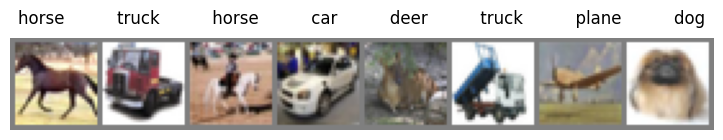

In [ ]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5  # Unnormalize the image
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

# Function to showcase random samples]
def show_samples_with_labels(dataset, num_samples=8):
    # Get random samples from the dataset
    dataiter = iter(dataset)
    images, labels = next(dataiter)

    # Create a grid of images
    img_grid = torchvision.utils.make_grid(images[:num_samples], nrow=num_samples, padding=2)

    # Display the images
    plt.figure(figsize=(num_samples * 2, 1.2))
    imshow(img_grid)

    class_names = [classes[labels[j]] for j in range(num_samples)]
    plt.title("          ".join(class_names), fontsize=12, pad=10)
    plt.show()

# Call the function to display a grid of samples
show_samples_with_labels(trainloader, num_samples=8)

### Task 1

#### Define the Simple CNN Model

- Conv Layer 1: 16 filters, 3x3 kernel, stride 1, padding 1.

- Conv Layer 2: 32 filters, 3x3 kernel, stride 1, padding 1.

- Max Pooling: A pooling layer after each convolutional layer to reduce spatial dimensions.

- Flattening: Converts the 2D feature maps into a 1D vector for the fully connected layer.

- Fully Connected Layer: Produces the output, a probability distribution over 10 classes.

We will use ReLU as the activation function for both convolutional layers and  Adam optimizer.

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # First convolutional layer
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        # Second convolutional layer
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        # Max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Fully connected layer for classification
        self.fc = nn.Linear(32 * 8 * 8, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, start_dim=1)
        x = self.fc(x)
        return x

model = SimpleCNN()
# optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss

print(model)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total number of parameters: {total_params}")

SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=2048, out_features=10, bias=True)
)
Total number of parameters: 25578


#### Train the CNN Model

In this step, we define and implement the training process for the CNN model.<br>
 The `train_model` function trains the model for 10 epochs using the Adam optimizer and CrossEntropyLoss.




In [ ]:
def train_and_validate_model(model, trainloader, validloader, optimizer, criterion, epochs=10):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # Training
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()
            optimizer.step()

            # Track training loss and accuracy
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(trainloader)
        train_accuracy = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in validloader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # Track validation loss and accuracy
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_loss = val_loss / len(validloader)
        val_accuracy = 100 * correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{epochs}, "
              f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    return train_losses, train_accuracies, val_losses, val_accuracies

train_losses, train_accuracies, val_losses, val_accuracies = train_and_validate_model(
    model, trainloader, valloader, optimizer, criterion, epochs=10)

Epoch 1/10, Train Loss: 1.5091, Train Accuracy: 46.44%, Val Loss: 1.2604, Val Accuracy: 56.18%
Epoch 2/10, Train Loss: 1.2038, Train Accuracy: 57.59%, Val Loss: 1.1458, Val Accuracy: 60.30%
Epoch 3/10, Train Loss: 1.0883, Train Accuracy: 61.99%, Val Loss: 1.0918, Val Accuracy: 62.42%
Epoch 4/10, Train Loss: 1.0071, Train Accuracy: 65.08%, Val Loss: 1.0491, Val Accuracy: 64.13%
Epoch 5/10, Train Loss: 0.9489, Train Accuracy: 67.05%, Val Loss: 1.0053, Val Accuracy: 65.36%
Epoch 6/10, Train Loss: 0.9018, Train Accuracy: 68.90%, Val Loss: 0.9868, Val Accuracy: 66.10%
Epoch 7/10, Train Loss: 0.8601, Train Accuracy: 70.11%, Val Loss: 0.9572, Val Accuracy: 67.15%
Epoch 8/10, Train Loss: 0.8252, Train Accuracy: 71.67%, Val Loss: 0.9653, Val Accuracy: 67.03%
Epoch 9/10, Train Loss: 0.8015, Train Accuracy: 72.08%, Val Loss: 0.9657, Val Accuracy: 67.21%
Epoch 10/10, Train Loss: 0.7737, Train Accuracy: 73.27%, Val Loss: 0.9669, Val Accuracy: 66.91%


#### Visualize Training Results

Here, we visualize the training results by plotting the loss and accuracy over the epochs.

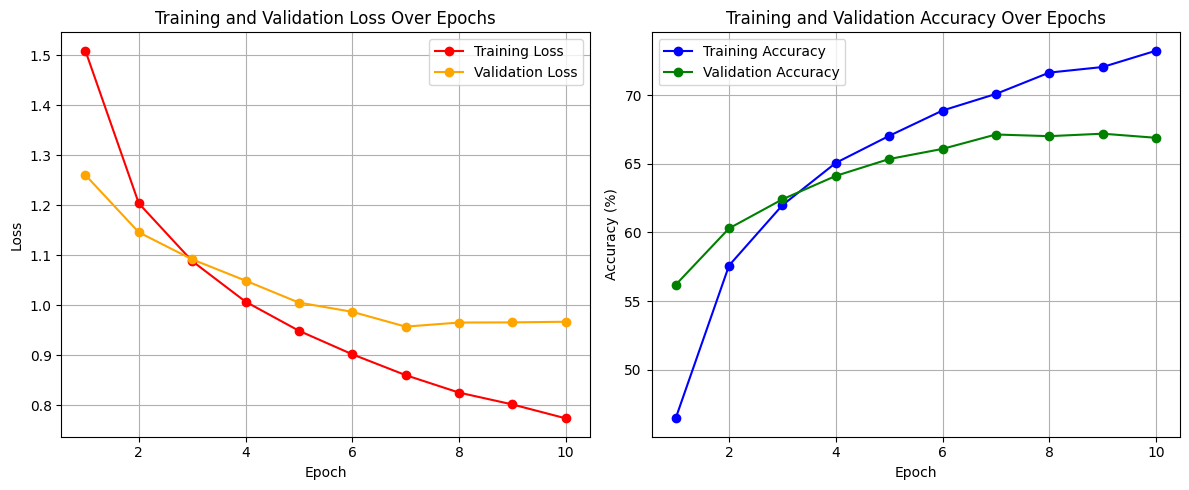

In [ ]:
def visualize_training_validation_results(
    train_losses, train_accuracies, val_losses, val_accuracies, title_prefix="Training and Validation"
):
    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss', color='red', marker='o')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', color='orange', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{title_prefix} Loss Over Epochs')
    plt.grid(True)
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Training Accuracy', color='blue', marker='o')
    plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy', color='green', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title(f'{title_prefix} Accuracy Over Epochs')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

visualize_training_validation_results(train_losses, train_accuracies, val_losses, val_accuracies)


#### Evaluate the Model on the Test Dataset

After training the CNN model, we evaluate its performance on the test dataset.

In [ ]:
def evaluate_model(model, testloader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

# Evaluate the model on the test set
simple_test_accuracy = evaluate_model(model, testloader)


Test Accuracy: 66.61%


#### Visualize Feature Maps

In this step, we visualize the feature maps produced by the first convolutional layer of the model. The process involves:

- Selecting a random image from the test set.
- Passing the image through the first convolutional layer (conv1) of the model.
- Extracting and plotting the 16 feature maps, which correspond to the 16 filters in the first layer.



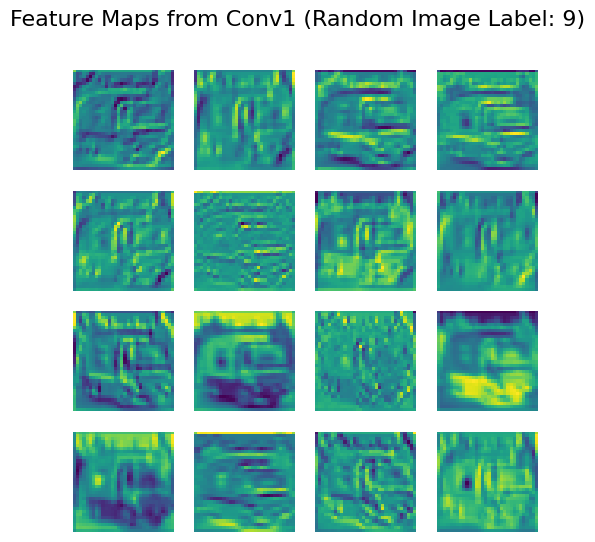

In [ ]:
def visualize_feature_maps(model, testloader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    # Get a random batch of data
    dataiter = iter(testloader)
    inputs, labels = next(dataiter)

    # Choose a random index from the batch
    random_index = random.randint(0, inputs.size(0) - 1)
    random_image = inputs[random_index:random_index + 1]
    random_label = labels[random_index].item()

    random_image = random_image.to(device)

    # Extract feature maps from the first convolutional layer
    model.eval()
    with torch.no_grad():
        feature_maps = model.conv1(random_image)

    # Move feature maps back to CPU for visualization
    feature_maps = feature_maps.cpu()

    # Plot the feature maps
    fig, axes = plt.subplots(4, 4, figsize=(6, 6))
    for i, ax in enumerate(axes.flat):
        if i < feature_maps.shape[1]:
            ax.imshow(feature_maps[0, i].detach().numpy(), cmap='viridis')
            ax.axis('off')
    plt.suptitle(f"Feature Maps from Conv1 (Random Image Label: {random_label})", fontsize=16)
    plt.show()

    return random_index

random_image_index = visualize_feature_maps(model, testloader)


The feature maps extracted from the first convolutional layer reveal how the model processes and transforms the input image into different feature representations. Each feature map highlights specific patterns, edges, or textures in the image, demonstrating the model's focus on distinct visual features. In this case, the feature maps showcase the network's ability to capture meaningful characteristics of the input image, such as the shape and structure of the object, providing insights into how the model learns and interprets the data during training.

### Task 2

#### Define the deeper CNN Model

The deeper model has 4 convolutional layers:
- Conv1: 16 filters, 3x3 kernel, stride 1, padding 1.

- Conv2: 32 filters, 3x3 kernel, stride 1, padding 1.

- Conv3: 64 filters, 3x3 kernel, stride 1, padding 1.

- Conv4: 128 filters, 3x3 kernel, stride 1, padding 1.

Each convolutional layer is followed by a ReLU activation function and a Max Pooling layer to reduce spatial dimensions.<br>

A fully connected layer at the end maps the features to 10 output classes.<br>

We use ReLU as the activation function for the convolutional layers and Adam optimizer.





In [ ]:
class DeepCNN(nn.Module):
    def __init__(self):
        super(DeepCNN, self).__init__()
        # First convolutional layer
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        # Second convolutional layer
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        # Third convolutional layer
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        # Fourth convolutional layer
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        # Max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Fully connected layer
        self.fc = nn.Linear(128 * 2 * 2, 10)

    def forward(self, x):
        # Apply convolutional layers with ReLU and max pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        # Flatten the output
        x = torch.flatten(x, start_dim=1)
        # Fully connected layer
        x = self.fc(x)
        return x

deep_model = DeepCNN()

# optimizer and loss function
optimizer = optim.Adam(deep_model.parameters(), lr=0.001)  # Adam optimizer
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss

print(deep_model)

total_params = sum(p.numel() for p in deep_model.parameters() if p.requires_grad)
print(f"Total number of parameters: {total_params}")


DeepCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=512, out_features=10, bias=True)
)
Total number of parameters: 102570


#### Train the Model

We will train the deeper network using the Adam optimizer and CrossEntropyLoss for 10 epochs, like the previous model.

In [ ]:
# Train the deeper model
deep_losses, deep_accuracies, deep_val_losses, deep_val_accuracies = train_and_validate_model(
    deep_model, trainloader, valloader, optimizer, criterion, epochs=10
)

Epoch 1/10, Train Loss: 1.5731, Train Accuracy: 42.78%, Val Loss: 1.3256, Val Accuracy: 52.68%
Epoch 2/10, Train Loss: 1.1787, Train Accuracy: 57.73%, Val Loss: 1.1025, Val Accuracy: 61.07%
Epoch 3/10, Train Loss: 0.9946, Train Accuracy: 64.83%, Val Loss: 0.9620, Val Accuracy: 66.39%
Epoch 4/10, Train Loss: 0.8720, Train Accuracy: 69.29%, Val Loss: 0.9196, Val Accuracy: 67.98%
Epoch 5/10, Train Loss: 0.7776, Train Accuracy: 72.58%, Val Loss: 0.9108, Val Accuracy: 68.47%
Epoch 6/10, Train Loss: 0.7052, Train Accuracy: 75.24%, Val Loss: 0.8955, Val Accuracy: 69.28%
Epoch 7/10, Train Loss: 0.6386, Train Accuracy: 77.68%, Val Loss: 0.8315, Val Accuracy: 71.78%
Epoch 8/10, Train Loss: 0.5783, Train Accuracy: 79.61%, Val Loss: 0.8411, Val Accuracy: 71.91%
Epoch 9/10, Train Loss: 0.5245, Train Accuracy: 81.77%, Val Loss: 0.8694, Val Accuracy: 71.58%
Epoch 10/10, Train Loss: 0.4762, Train Accuracy: 83.25%, Val Loss: 0.8586, Val Accuracy: 72.35%


#### Visualize Results for the Deeper Model

here we visualize the training loss and accuracy over epochs for the deeper model.

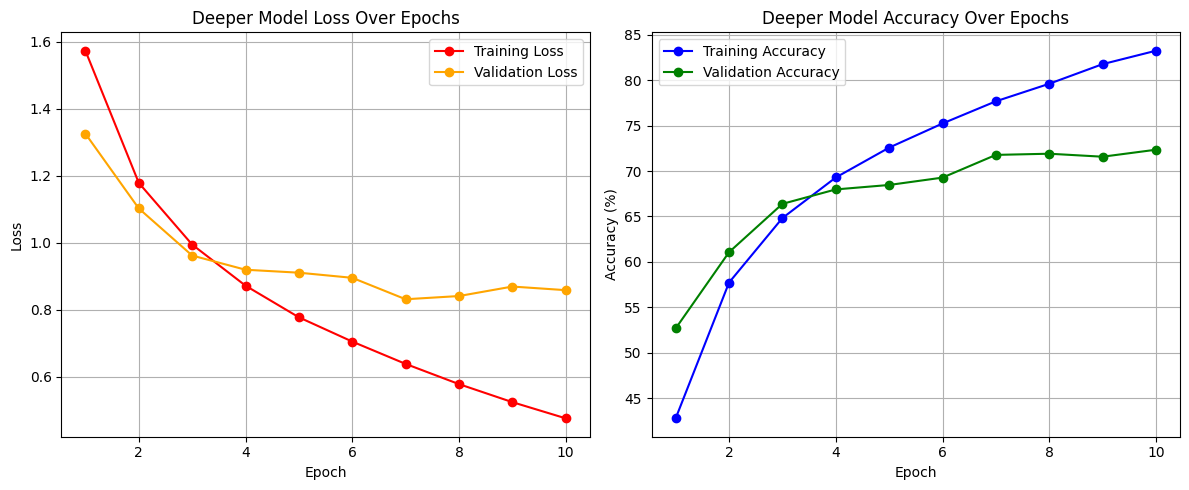

In [ ]:
visualize_training_validation_results(
    deep_losses,
    deep_accuracies,
    val_losses=deep_val_losses,
    val_accuracies=deep_val_accuracies,
    title_prefix="Deeper Model"
)

#### Evaluate the Model on the Test Dataset

Now that we have visualized the training results for the deeper model, we will evaluate its performance on the test dataset to determine how well it generalizes to unseen data.



In [ ]:
deeper_test_accuracy = evaluate_model(deep_model, testloader)

Test Accuracy: 72.30%


#### Compare Results Between Simple and Deep Models

Now that you have the training and testing results for both models, we will compare their performance.

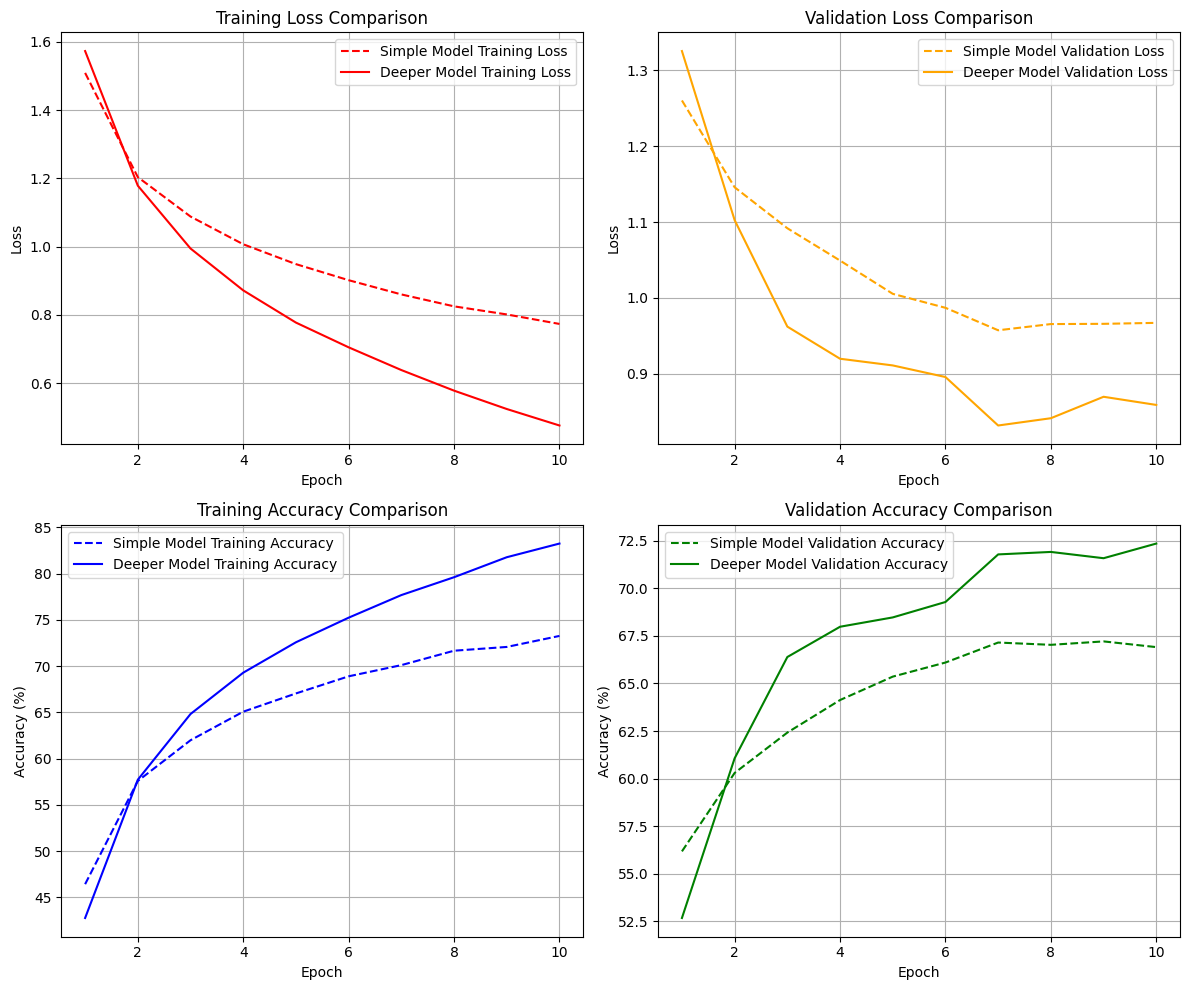



Simple Model Test Accuracy: 66.61%
Deeper Model Test Accuracy: 72.30%


In [ ]:
def compare_training_results(losses1, accuracies1, val_losses1, val_accuracies1,
                             losses2, accuracies2, val_losses2, val_accuracies2,
                             label1, label2):
    plt.figure(figsize=(12, 10))

    # Training Loss comparison
    plt.subplot(2, 2, 1)
    plt.plot(range(1, len(losses1) + 1), losses1, label=f'{label1} Training Loss', color='red', linestyle='--')
    plt.plot(range(1, len(losses2) + 1), losses2, label=f'{label2} Training Loss', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Comparison')
    plt.grid(True)
    plt.legend()

    # Validation Loss comparison
    plt.subplot(2, 2, 2)
    plt.plot(range(1, len(val_losses1) + 1), val_losses1, label=f'{label1} Validation Loss', color='orange', linestyle='--')
    plt.plot(range(1, len(val_losses2) + 1), val_losses2, label=f'{label2} Validation Loss', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Validation Loss Comparison')
    plt.grid(True)
    plt.legend()

    # Training Accuracy comparison
    plt.subplot(2, 2, 3)
    plt.plot(range(1, len(accuracies1) + 1), accuracies1, label=f'{label1} Training Accuracy', color='blue', linestyle='--')
    plt.plot(range(1, len(accuracies2) + 1), accuracies2, label=f'{label2} Training Accuracy', color='blue')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training Accuracy Comparison')
    plt.grid(True)
    plt.legend()

    # Validation Accuracy comparison
    plt.subplot(2, 2, 4)
    plt.plot(range(1, len(val_accuracies1) + 1), val_accuracies1, label=f'{label1} Validation Accuracy', color='green', linestyle='--')
    plt.plot(range(1, len(val_accuracies2) + 1), val_accuracies2, label=f'{label2} Validation Accuracy', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Validation Accuracy Comparison')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()


compare_training_results(
    train_losses, train_accuracies, val_losses, val_accuracies,
    deep_losses, deep_accuracies, deep_val_losses, deep_val_accuracies,
    label1="Simple Model", label2="Deeper Model"
)

print("\n")
# test accuracies for both models
print(f"Simple Model Test Accuracy: {simple_test_accuracy:.2f}%")
print(f"Deeper Model Test Accuracy: {deeper_test_accuracy:.2f}%")



### Task 3

#### Define the Updated Model

- The first layer has 16 filters with a kernel size of 5x5 and a stride of 2.

- The second layer has 32 filters with the same kernel size and stride.

- A pooling layer is applied after each convolutional layer.

- The output from the convolutional layers is flattened and passed through a fully connected layer to classify the 10 classes.

We use ReLU as the activation function for both convolutional layers and Adam optimizer.


In [ ]:
class UpdatedCNN(nn.Module):
    def __init__(self):
        super(UpdatedCNN, self).__init__()
        # First convolutional layer
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2, padding=1)
        # Second convolutional layer
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2, padding=1)
        # Max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Fully connected layer
        self.fc = nn.Linear(32 * 1 * 1, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, start_dim=1)
        x = self.fc(x)
        return x

updated_model = UpdatedCNN()

# optimizer and loss function
optimizer = torch.optim.Adam(updated_model.parameters(), lr=0.001)  # Adam optimizer
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss

print(updated_model)

total_params = sum(p.numel() for p in updated_model.parameters() if p.requires_grad)
print(f"Total number of parameters: {total_params}")

UpdatedCNN(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=32, out_features=10, bias=True)
)
Total number of parameters: 14378


#### Train the Model

We will train the updated network using the Adam optimizer and CrossEntropyLoss for 10 epochs, like the previous model.

In [ ]:
updated_losses, updated_accuracies, updated_val_losses, updated_val_accuracies = train_and_validate_model(
    updated_model, trainloader, valloader, optimizer, criterion, epochs=10
)

Epoch 1/10, Train Loss: 1.7226, Train Accuracy: 37.72%, Val Loss: 1.5099, Val Accuracy: 45.34%
Epoch 2/10, Train Loss: 1.4389, Train Accuracy: 48.71%, Val Loss: 1.4045, Val Accuracy: 50.49%
Epoch 3/10, Train Loss: 1.3524, Train Accuracy: 52.06%, Val Loss: 1.3543, Val Accuracy: 52.25%
Epoch 4/10, Train Loss: 1.2972, Train Accuracy: 54.23%, Val Loss: 1.2971, Val Accuracy: 54.29%
Epoch 5/10, Train Loss: 1.2536, Train Accuracy: 55.71%, Val Loss: 1.2643, Val Accuracy: 55.94%
Epoch 6/10, Train Loss: 1.2162, Train Accuracy: 57.22%, Val Loss: 1.2463, Val Accuracy: 56.34%
Epoch 7/10, Train Loss: 1.1880, Train Accuracy: 58.38%, Val Loss: 1.2509, Val Accuracy: 56.41%
Epoch 8/10, Train Loss: 1.1673, Train Accuracy: 58.94%, Val Loss: 1.2133, Val Accuracy: 57.27%
Epoch 9/10, Train Loss: 1.1451, Train Accuracy: 59.78%, Val Loss: 1.2078, Val Accuracy: 57.78%
Epoch 10/10, Train Loss: 1.1268, Train Accuracy: 60.30%, Val Loss: 1.2013, Val Accuracy: 58.07%


#### Visualize Training Results for the Updated Model

let’s visualize the training results for the updated model to evaluate its loss and accuracy over epochs.

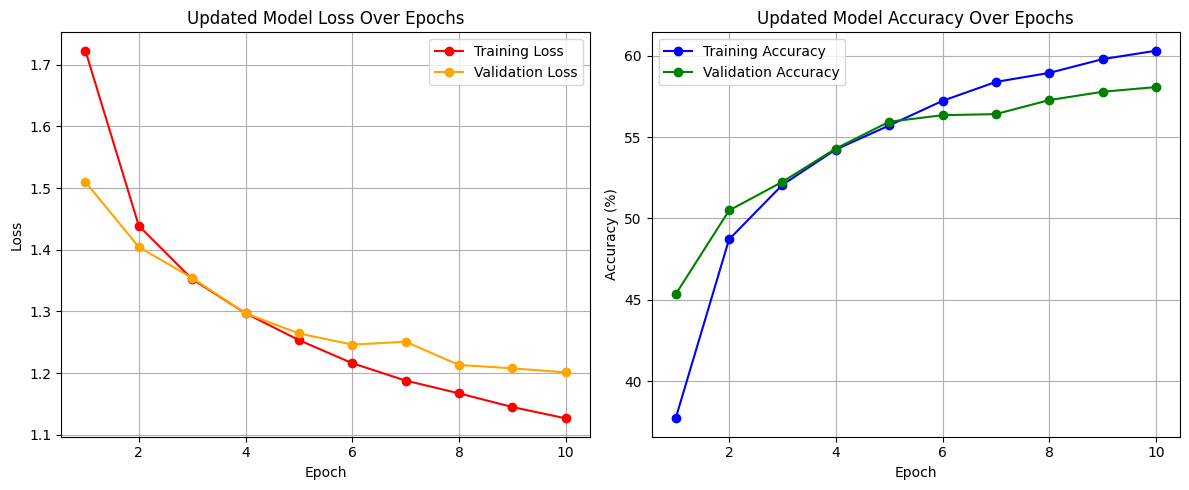

In [ ]:
visualize_training_validation_results(
    updated_losses,
    updated_accuracies,
    val_losses=updated_val_losses,
    val_accuracies=updated_val_accuracies,
    title_prefix="Updated Model"
)

#### Test the Updated Model

After training the updated model, we now evaluate its performance on the test dataset.

In [ ]:
updated_test_accuracy = evaluate_model(updated_model, testloader)

Test Accuracy: 57.86%


####  Compare Results Across Models

Now that we have the training and testing results for all models (Simple Model, Deeper Model, and Updated Model), we can compare their performances.

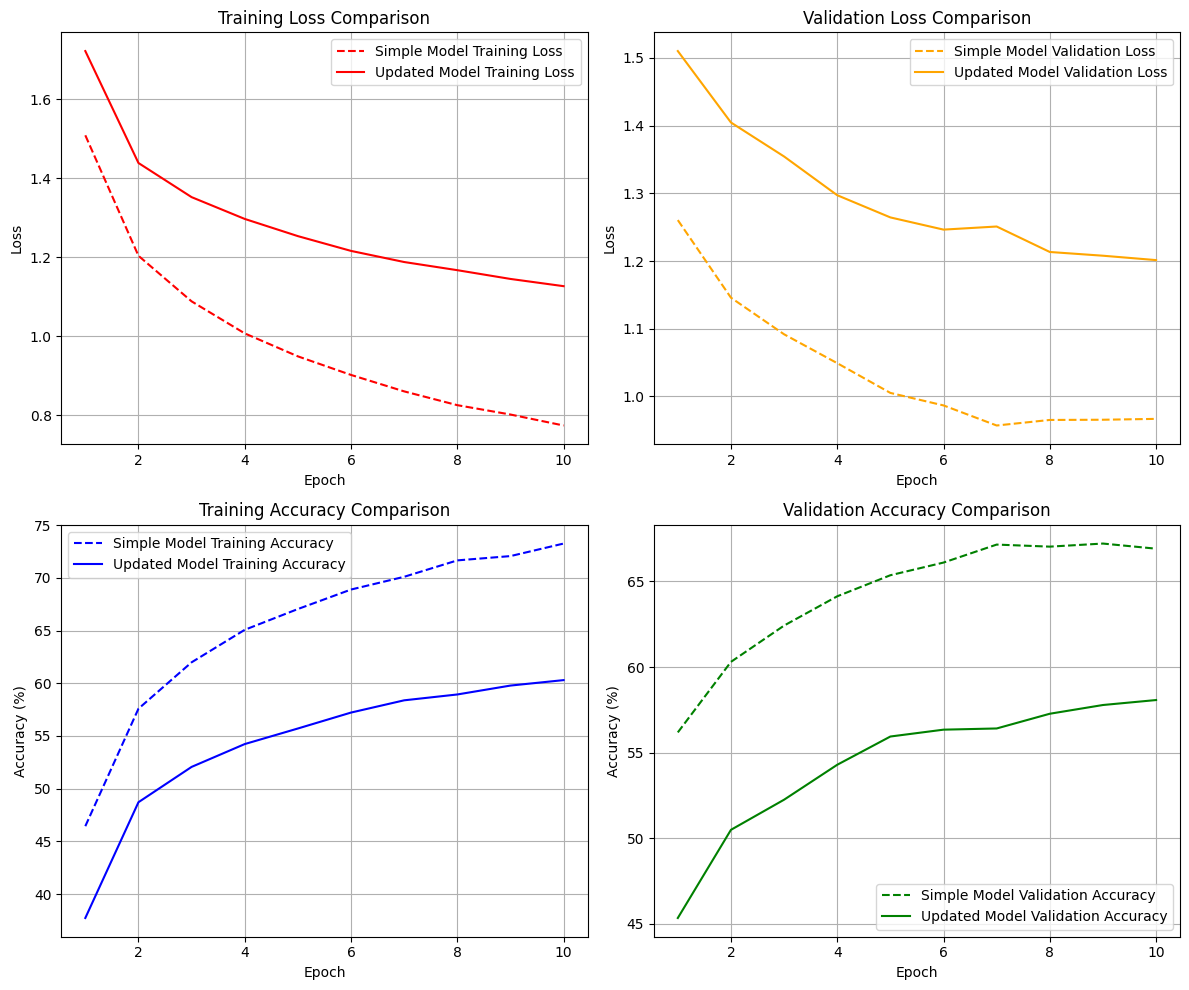

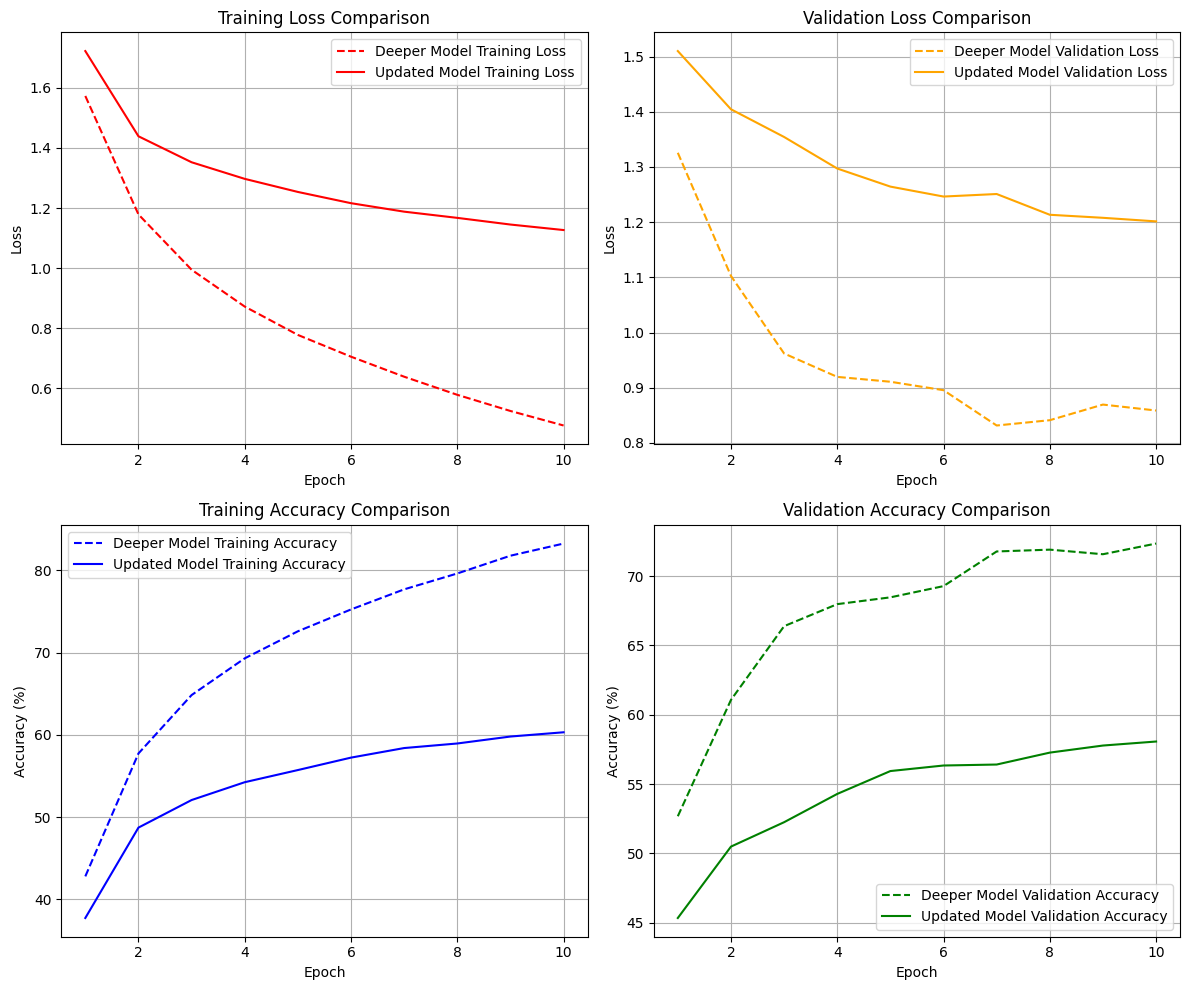



Simple Model Test Accuracy: 66.61%
Deeper Model Test Accuracy: 72.30%
Updated Model Test Accuracy: 57.86%


In [ ]:
# Simple Model vs. Updated Model
compare_training_results(
    train_losses, train_accuracies, val_losses, val_accuracies,
    updated_losses, updated_accuracies, updated_val_losses, updated_val_accuracies,
    label1="Simple Model", label2="Updated Model"
)

# Deeper Model vs. Updated Model
compare_training_results(
    deep_losses, deep_accuracies, deep_val_losses, deep_val_accuracies,
    updated_losses, updated_accuracies, updated_val_losses, updated_val_accuracies,
    label1="Deeper Model", label2="Updated Model"
)

print("\n")
print(f"Simple Model Test Accuracy: {simple_test_accuracy:.2f}%")
print(f"Deeper Model Test Accuracy: {deeper_test_accuracy:.2f}%")
print(f"Updated Model Test Accuracy: {updated_test_accuracy:.2f}%")



The comparison highlights that the Deeper Model achieves the highest test accuracy (72.30%), outperforming both the Simple Model (66.61%) and the Updated Model (57.86%). While the updated model shows comparable loss reduction during training, its lower test accuracy suggests weaker generalization, likely due to architectural changes such as increased kernel size and stride.

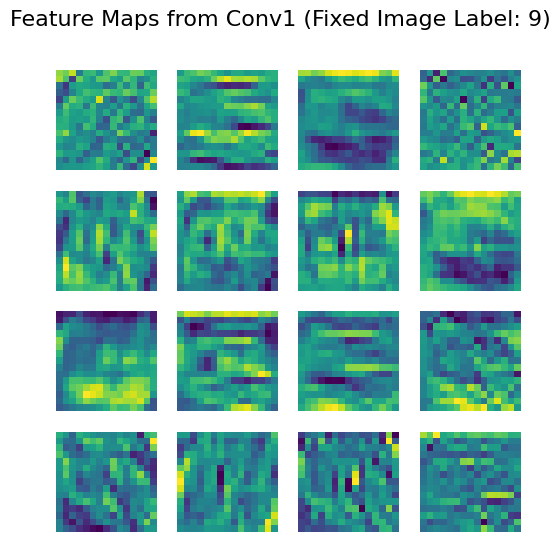

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def visualize_feature_maps_with_index(model, testloader, image_index):
    # Get the entire dataset from the testloader
    all_inputs, all_labels = next(iter(testloader))

    # Extract the fixed image and label using the given index
    fixed_image = all_inputs[image_index:image_index + 1].to(device)
    fixed_label = all_labels[image_index].item()

    # Move model to the appropriate device
    model = model.to(device)

    # Extract feature maps from the first convolutional layer
    model.eval()
    with torch.no_grad():
        feature_maps = model.conv1(fixed_image)

    # Move feature maps back to CPU for visualization
    feature_maps = feature_maps.cpu()

    # Plot the feature maps
    fig, axes = plt.subplots(4, 4, figsize=(6, 6))
    for i, ax in enumerate(axes.flat):
        if i < feature_maps.shape[1]:
            ax.imshow(feature_maps[0, i].detach().numpy(), cmap='viridis')
            ax.axis('off')
    plt.suptitle(f"Feature Maps from Conv1 (Fixed Image Label: {fixed_label})", fontsize=16)
    plt.show()

# Use the same image index
visualize_feature_maps_with_index(updated_model, testloader, image_index=random_image_index)


The feature maps from the first convolutional layer of the updated model reflect how the changes in architecture (kernel size and stride) affect the learning process. Compared to the earlier models, these feature maps show broader spatial features due to the larger receptive field created by the 5x5 kernel and stride of 2. This adjustment reduces the spatial resolution, resulting in less fine-grained details. While the model still captures edges and patterns, the reduced resolution might contribute to the lower test accuracy observed earlier, as it could miss some finer details critical for classification.

### Task 4

#### define the Best Model (Deeper Model) with Average Pooling

We modify the Deeper Model by replacing the Max Pooling layers with Average Pooling layers.

In [ ]:
class DeeperModelWithAvgPooling(nn.Module):
    def __init__(self):
        super(DeeperModelWithAvgPooling, self).__init__()
        # First convolutional layer
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        # Second convolutional layer
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        # Third convolutional layer
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        # Fourth convolutional layer
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        # Average pooling layer
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        # Fully connected layer
        self.fc = nn.Linear(128 * 2 * 2, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = torch.flatten(x, start_dim=1)
        x = self.fc(x)
        return x

avg_pooling_model = DeeperModelWithAvgPooling()

# optimizer and loss function
optimizer = torch.optim.Adam(avg_pooling_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

print(avg_pooling_model)

total_params = sum(p.numel() for p in avg_pooling_model.parameters() if p.requires_grad)
print(f"Total number of parameters: {total_params}")

DeeperModelWithAvgPooling(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc): Linear(in_features=512, out_features=10, bias=True)
)
Total number of parameters: 102570


#### Train the Model

We will train the updated model with Average Pooling layers for 10 epochs using the Adam optimizer and CrossEntropyLoss.

In [ ]:
# Train the average pooling model
avg_pooling_losses, avg_pooling_accuracies, avg_validation_losses, avg_validation_accuracies = train_and_validate_model(
    avg_pooling_model, trainloader, valloader, optimizer, criterion, epochs=10
)

Epoch 1/10, Train Loss: 1.6938, Train Accuracy: 37.46%, Val Loss: 1.5014, Val Accuracy: 45.74%
Epoch 2/10, Train Loss: 1.4110, Train Accuracy: 48.78%, Val Loss: 1.3367, Val Accuracy: 52.39%
Epoch 3/10, Train Loss: 1.2838, Train Accuracy: 53.73%, Val Loss: 1.2477, Val Accuracy: 55.94%
Epoch 4/10, Train Loss: 1.1859, Train Accuracy: 57.55%, Val Loss: 1.1778, Val Accuracy: 58.66%
Epoch 5/10, Train Loss: 1.0982, Train Accuracy: 60.98%, Val Loss: 1.1054, Val Accuracy: 61.14%
Epoch 6/10, Train Loss: 1.0304, Train Accuracy: 63.59%, Val Loss: 1.0990, Val Accuracy: 61.29%
Epoch 7/10, Train Loss: 0.9665, Train Accuracy: 65.94%, Val Loss: 1.0368, Val Accuracy: 63.65%
Epoch 8/10, Train Loss: 0.9154, Train Accuracy: 67.58%, Val Loss: 0.9676, Val Accuracy: 67.00%
Epoch 9/10, Train Loss: 0.8610, Train Accuracy: 69.60%, Val Loss: 0.9331, Val Accuracy: 67.71%
Epoch 10/10, Train Loss: 0.8123, Train Accuracy: 71.38%, Val Loss: 0.9422, Val Accuracy: 67.54%


#### Visualize Training Results for the Model with Average Pooling

we will visualize the training loss and accuracy of the model with Average Pooling.

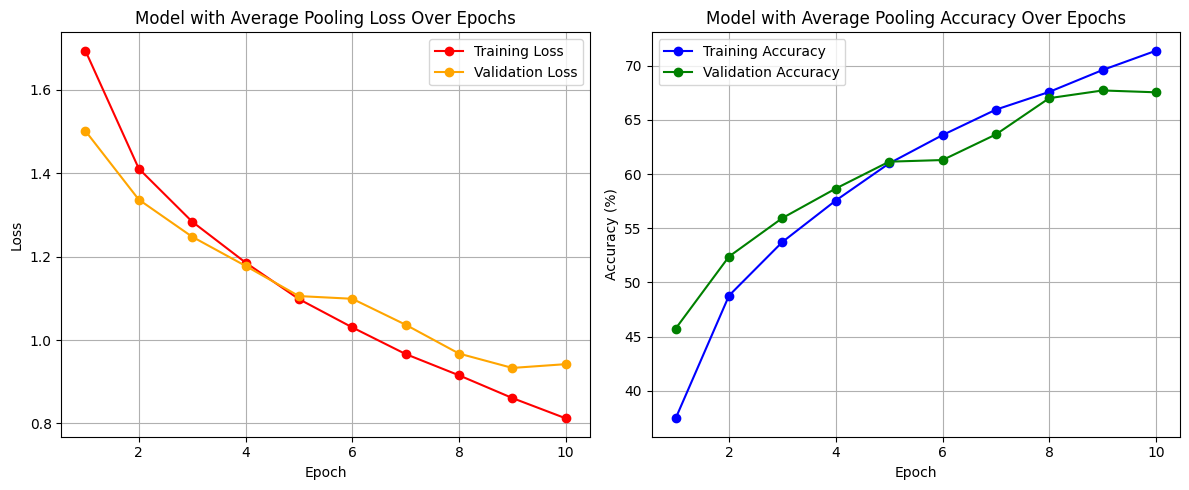

In [ ]:
visualize_training_validation_results(
    avg_pooling_losses,
    avg_pooling_accuracies,
    avg_validation_losses,
    avg_validation_accuracies,
    title_prefix="Model with Average Pooling"
)

#### Evaluate the Model on the Test Dataset

After training, we evaluate the test accuracy of the model with Average Pooling on the test dataset.

In [ ]:
avg_pooling_test_accuracy = evaluate_model(avg_pooling_model, testloader)

Test Accuracy: 66.38%


#### Compare the Model with Average Pooling to the Deeper Model

here, we compare the training loss, training accuracy, and test accuracy of the Deeper Model (Max Pooling) and the Model with Average Pooling

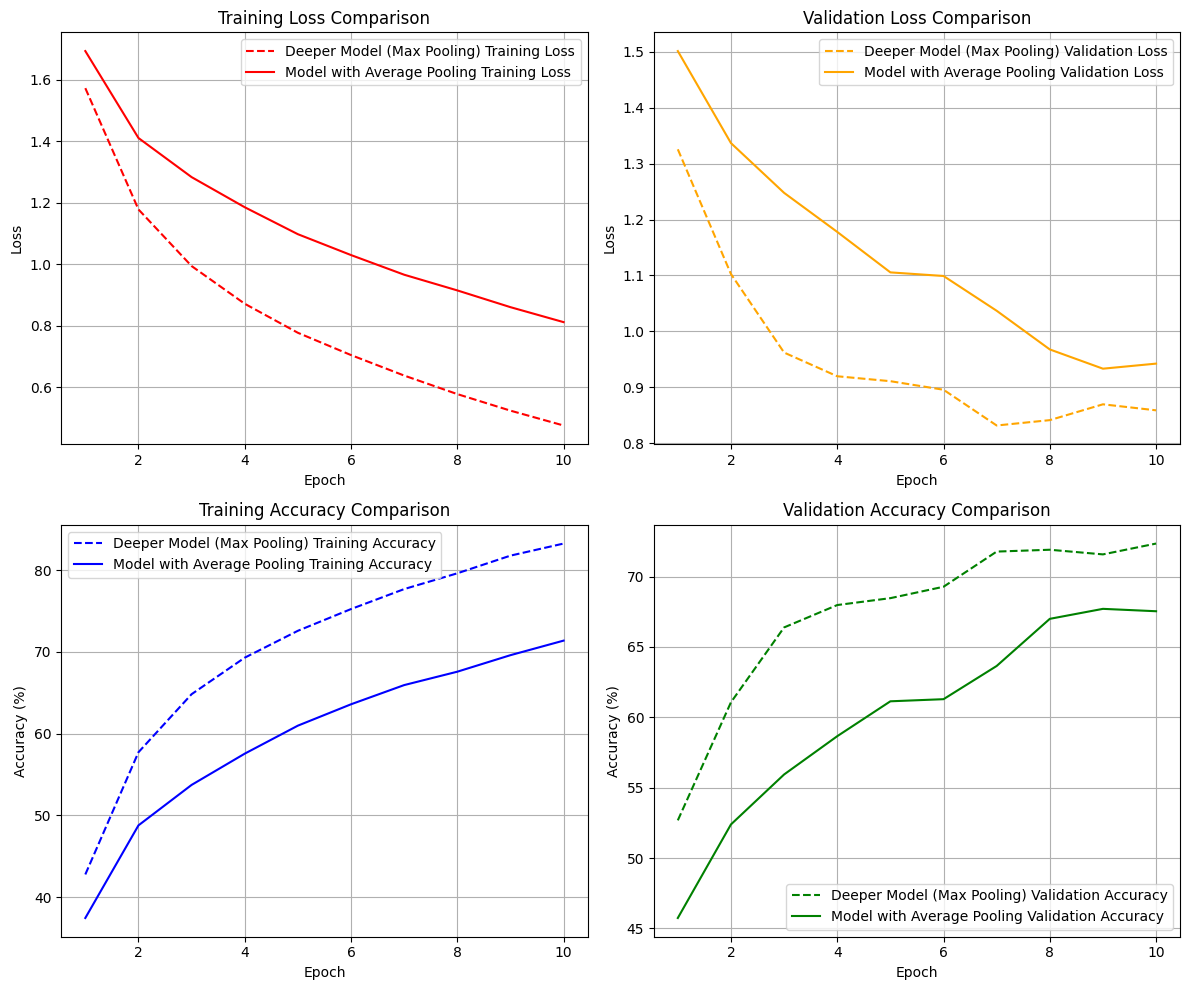



Deeper Model (Max Pooling) Test Accuracy: 72.30%
Model with Average Pooling Test Accuracy: 66.38%


In [ ]:
# Deeper Model (Max Pooling) vs. Model with Average Pooling
compare_training_results(deep_losses, deep_accuracies, deep_val_losses, deep_val_accuracies,
                        avg_pooling_losses, avg_pooling_accuracies, avg_validation_losses, avg_validation_accuracies,
                        label1="Deeper Model (Max Pooling)", label2="Model with Average Pooling")

print("\n")
# test accuracies for both models
print(f"Deeper Model (Max Pooling) Test Accuracy: {deeper_test_accuracy:.2f}%")
print(f"Model with Average Pooling Test Accuracy: {avg_pooling_test_accuracy:.2f}%")



The Deeper Model with Max Pooling **outperformed** the Model with Average Pooling in both training and test accuracy. While both models showed steady improvement during training, the Max Pooling model achieved higher accuracy and converged faster. This suggests that Max Pooling, by focusing on the most prominent features in the spatial dimensions, helps the model learn more discriminative features, leading to better generalization on the test set. In contrast, Average Pooling averages out features, which may smooth important details and slightly reduce the model's capacity to differentiate between classes.

In [ ]:
# Print a summary of all test accuracies
print("Summary of Test Accuracies:\n")

print(f"Simple Model Test Accuracy: {simple_test_accuracy:.2f}%")
print(f"Deeper Model Test Accuracy: {deeper_test_accuracy:.2f}%")
print(f"Updated Model Test Accuracy: {updated_test_accuracy:.2f}%")
print(f"Model with Average Pooling Test Accuracy: {avg_pooling_test_accuracy:.2f}%")


Summary of Test Accuracies:

Simple Model Test Accuracy: 66.61%
Deeper Model Test Accuracy: 72.30%
Updated Model Test Accuracy: 57.86%
Model with Average Pooling Test Accuracy: 66.38%


The Simple Model achieved a test accuracy of 66.61%, serving as the baseline. The Deeper Model, with additional layers and increased complexity, performed the best with a test accuracy of 72.30%, demonstrating its ability to capture more complex patterns in the data. The Updated Model, which modified kernel sizes and strides, resulted in a reduced test accuracy of 57.86%, indicating that these changes might have negatively impacted the model's ability to generalize. Lastly, the Model with Average Pooling achieved a test accuracy of 66.38%, comparable to the Simple Model but slightly lower, suggesting that average pooling may not provide significant improvements in this specific context. Overall, the Deeper Model proved to be the most effective configuration.